### Data Science Programming - Final Project
### Assessing Post-Natural Disaster Building Damage via Satellite Imagery
#### Team members: Alysson De Oliveira Silveira, Daniel Cordner, Manuel Salgueiro Gentile, Saahil Rasheed, Sai Sri Vathsava Udathu

## CNN + ResNet50 Model 
This notebook contains all the data preparation steps necessary to fit the CNN + ResNet50 Model. Note: Our models are presented in different notebooks and the data preparation part was reapeated in all of them, so they can work sepatelly. Anyway, if fitting more than one model in sequence, you may want to skip the data processing steps.

Our project aims to assess the damage caused by natural disasters using as input high quality satellite images.
The dataset we used in this project was made available for the xView2 Challenge, and contains 2799 pairs of images, pre and post disaster.
After downloaded and unzipped, the is split into two folders: image and labels. The first one, contains png pictures that can contains one or several buildings. 
The second folder contain json files that, among other information, displays the coordinates to each building and a label describing the level of demage.

#### 1.Preprocessing - Creating mask files

The codes shown below were adapted from 'https://github.com/DIUx-xView/xView2_baseline'.
We modified the codes to simplify the project for several reasons:
- lack of computational power
- time constraints
- this is the first experience with image analysis for all the members of our group.

Ps. Just a few functions weren't adapated for this peoject. For those, included an observation to highlight that they are identical to the original.


In [ ]:
# The first step was to create masks to delimit buildings, and to acomplish so, we had to get the coordinates from the json files.

In [1]:
import json
from os import path, walk, makedirs
from sys import exit, stderr
import os
from cv2 import fillPoly
import cv2
import numpy as np
from shapely import wkt
from shapely.geometry import mapping, Polygon
from shapely.wkt import loads
from skimage.io import imread
from tqdm import tqdm
import imantics 
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
root_folder = r'C:\Users\alyss\Desktop\MS BAIS\Fall 2020\ISM6251 - Data Science Programming\Final Project\train'
image_folder = path.join(root_folder, 'images')
json_folder = path.join(root_folder, 'labels')
mask_folder = path.join(root_folder, 'masks')

In [ ]:
#The function below was copied from https://github.com/DIUx-xView/xView2_first_place/blob/master/create_masks.py without changes

def mask_for_polygon(poly, im_size=(1024, 1024)):
    img_mask = np.zeros(im_size, np.uint8)
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords)]
    interiors = [int_coords(pi.coords) for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

def process_image(json_file):
    jfile = json.load(open(json_file))
    msk = np.zeros((1024, 1024), dtype='uint8')
    
    for feat in jfile['features']['xy']:
        poly = loads(feat['wkt'])
        _msk = mask_for_polygon(poly)
        msk[_msk > 0] = 255       
    cv2.imwrite(json_file.replace('labels', 'masks').replace('.json', '.png'), msk, [cv2.IMWRITE_PNG_COMPRESSION, 9])


In [ ]:
#getting image dimensions
def get_dims(chip_file):
    pil_img = imread(chip_file)
    img = np.array(pil_img)
    w, h, c = img.shape
    return w, h, c

In [ ]:
# getting polygon coordinates from json files       
def get_coord(chip_json):
    coordinates = {}
    for i in chip_json['features']['xy']:
        i_shape = wkt.loads(i['wkt'])
        coords = list(mapping(i_shape)['coordinates'][0])
        coordinates[i['properties']['uid']] = (np.array(coords, np.int32))
    return coordinates

In [ ]:
def save_mask(masked_polygons, mask_folder, mask_file_name):
    for m in masked_polygons:
        output = path.join(mask_folder, mask_file_name + '_{}.png'.format(m))
        cv2.imwrite(output, masked_polygons[m])

In [ ]:
def load_jsons(json_full_path):
    jdata = json.load(open(json_full_path))
    return jdata

In [ ]:
#Iterating through the folder containing json files and storing their names 
jsons = [j for j in next(walk(json_folder))[2]]

#iterating through json files, and making sure that are no files with other formats among them
for j in tqdm([j for j in jsons if j.endswith('json')], unit='poly', leave=False):
        #split the name of the file and the format, and replace .json by .png to access the images, as they have the same name standard 
        chip_img_id = path.splitext(j)[0] + '.png'
        #get file name without the extension. This will be used as the name of the mask file
        mask_file_name = path.splitext(j)[0]
        
        #reading json files
        json_full_path = path.join(json_folder, j)
        chip_json = load_jsons(json_full_path)

        #getting image dimensions
        chip_file = path.join(image_folder, chip_img_id)
        chip_size = get_dims(chip_file)

        # getting polygon coordinates from json files
        coordinates = get_coord(chip_json)
        
        #creating masks for each polygon using border=2 and saving mask images 
        process_image(json_full_path)
                


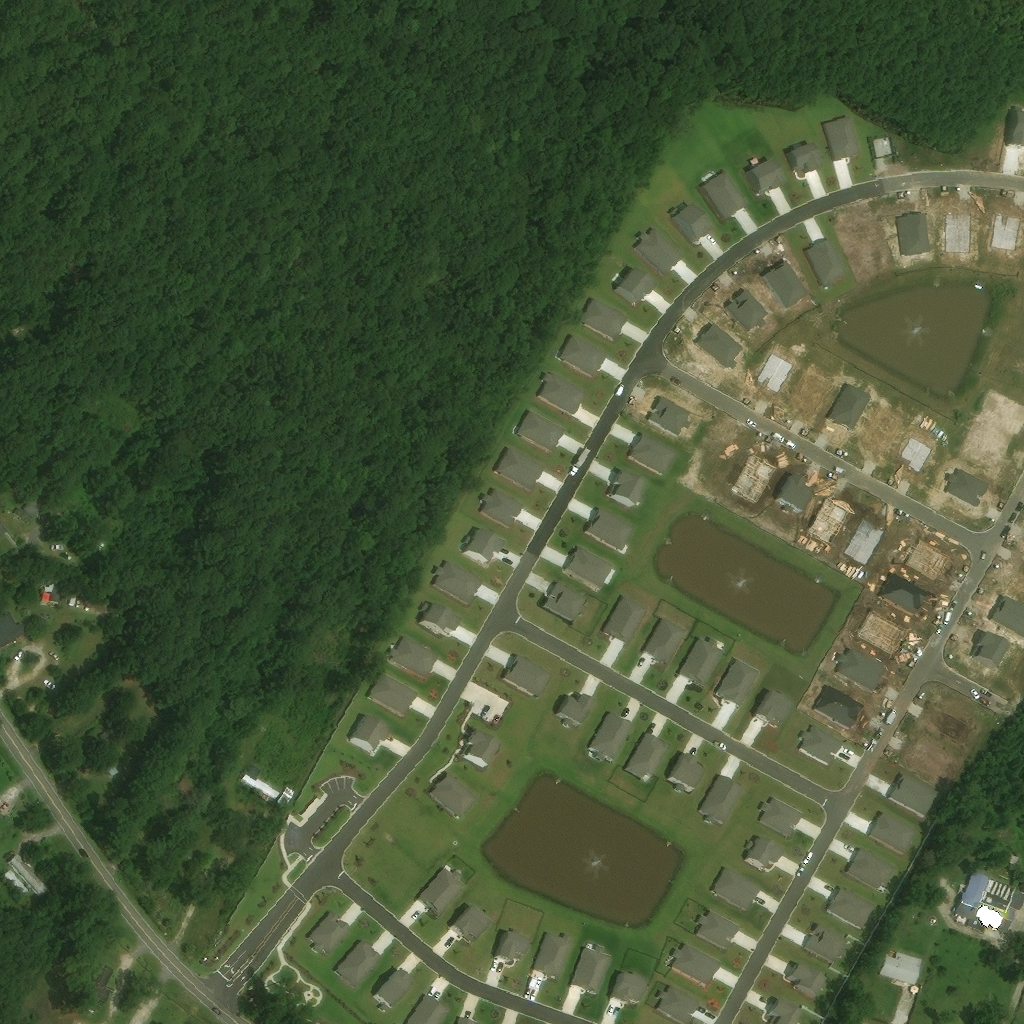

In [3]:
from IPython.display import Image
Image(filename='./train/images/hurricane-florence_00000001_pre_disaster.png', width=200)

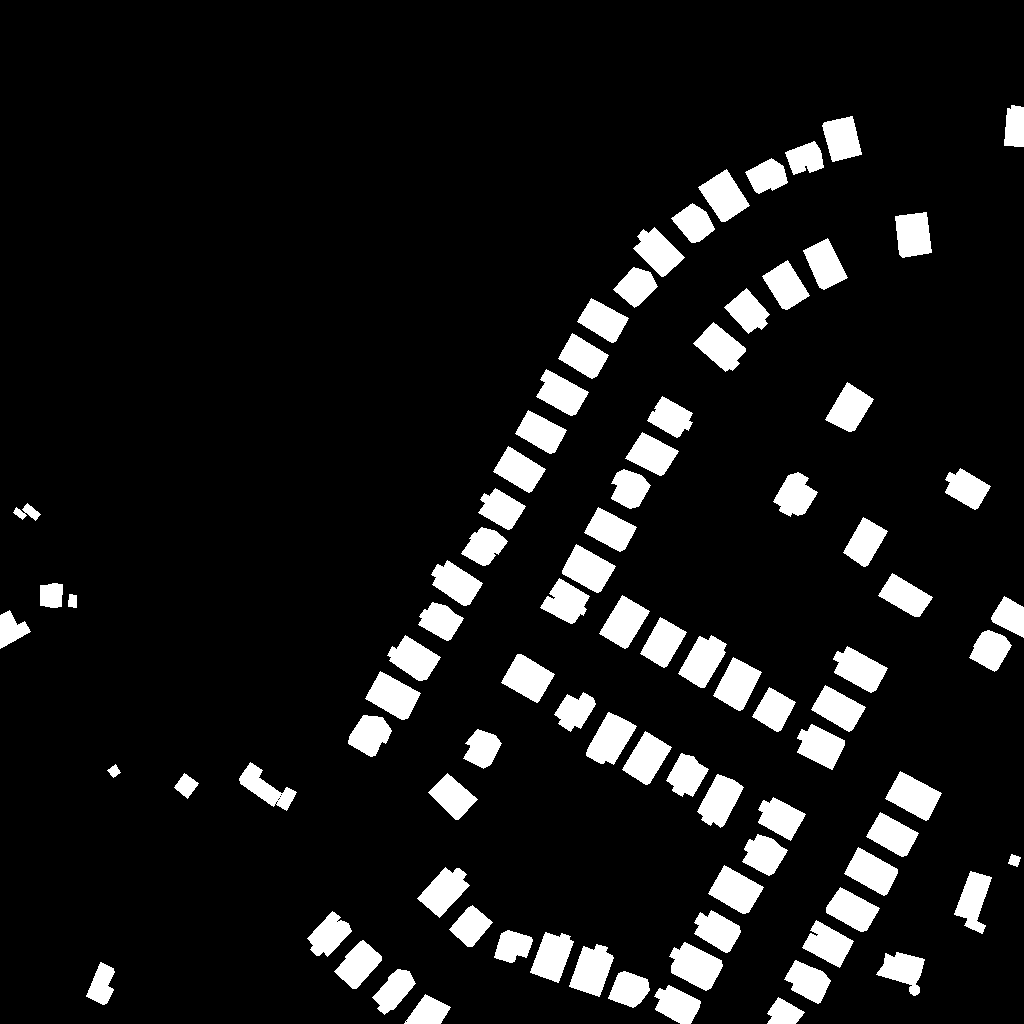

In [4]:
Image(filename='./train/masks/hurricane-florence_00000001_pre_disaster.png', width=200)

#### 2.Preprocessing - Spliting images 

One of the most challenging aspects of this project is that the analysis is at the building level and the images are not. So, after we recognized the buildings in each image, using its coordinates, we now need to create a separate image for each building and link it with the respective label. 

In [3]:
#Importing a new set of libraries to continue with the proprocessing
from PIL import Image
import time
import pandas as pd
import os
import math
import random
import logging
import datetime
import shapely
from collections import defaultdict
from sklearn.model_selection import train_test_split
logging.basicConfig(level=logging.INFO)

As the labels are displayed in text format, we need to encode it so later we can add it to the model.

In [4]:
damage = defaultdict(lambda: 0)
damage['destroyed'] = 3
damage['major-damage'] = 2
damage['minor-damage'] = 1
damage['no-damage'] = 0

Also, as we are not using the folder structure suggested by Ritwik Gupta in https://github.com/DIUx-xView/xView2_baseline, the code is way simpler than the original version

In [5]:
output_folder_pre = r'C:\Users\alyss\Desktop\MS BAIS\Fall 2020\ISM6251 - Data Science Programming\Final Project\Outputs\pre'
output_folder_post = r'C:\Users\alyss\Desktop\MS BAIS\Fall 2020\ISM6251 - Data Science Programming\Final Project\Outputs\post'
output_mask_folder_pre = r'C:\Users\alyss\Desktop\MS BAIS\Fall 2020\ISM6251 - Data Science Programming\Final Project\Outputs_masks\pre'
output_mask_folder_post = r'C:\Users\alyss\Desktop\MS BAIS\Fall 2020\ISM6251 - Data Science Programming\Final Project\Outputs_masks\post'

In [6]:
# This function finds the corners of each polygon.
# As it is a polygon, we are using the max coordinate on both x and y axis to create a square image
# The function was adapated to crop mask images as well

def process_img(img_array, polygon_pts, scale_pct):
    """Process Raw Data into
            Args:
                img_array (numpy array): numpy representation of image.
                polygon_pts (array): corners of the building polygon.
            Returns:
                numpy array: .
    """
    if len(img_array.shape) == 3:
        height, width, _ = img_array.shape
    else:
        height, width = img_array.shape

    xcoords = polygon_pts[:, 0]
    ycoords = polygon_pts[:, 1]
    xmin, xmax = np.min(xcoords), np.max(xcoords)
    ymin, ymax = np.min(ycoords), np.max(ycoords)

    xdiff = xmax - xmin
    ydiff = ymax - ymin

    #Extend image by scale percentage
    xmin = max(int(xmin - (xdiff * scale_pct)), 0)
    xmax = min(int(xmax + (xdiff * scale_pct)), width)
    ymin = max(int(ymin - (ydiff * scale_pct)), 0)
    ymax = min(int(ymax + (ydiff * scale_pct)), height)

    
    if len(img_array.shape) == 3:
        return img_array[ymin:ymax, xmin:xmax, :]
    else:
        return img_array[ymin:ymax, xmin:xmax]
      

In [9]:
# Creating one separate image per polygon 
# We also calculated the image mean and subtracted from the original array

x = []
y = []

images = [i for i in next(walk(image_folder))[2]]
for img in tqdm(images):
    if '_pre_' in img:
        output_folder = output_folder_pre
        output_mask_folder = output_mask_folder_pre
    else:
        output_folder = output_folder_post
        output_mask_folder = output_mask_folder_post
    
    #Opening each image and transforming it into a numpy array and subtracting the image mean
    imgage_obj = Image.open(path.join(image_folder, img))
    image_array = np.array(imgage_obj)
    #image_array = image_array - image_array.mean()
        
    #Getting the respective label for each picture
    label_path = path.join(image_folder.replace('images', 'labels'), img.replace('png', 'json'))
    label_file = open(label_path)
    label_data = json.load(label_file)
    
    mask_path = path.join(image_folder.replace('images', 'masks'), img)
    mask_obj = Image.open(mask_path)
    mask_array = np.array(mask_obj)


    for building in label_data['features']['xy']:
        #As pre-disaster images don't have a label, we assinged no-demage to them
        try:
            damage_type = building['properties']['subtype']
        except:
            damage_type = "no-damage"
        

        #Creating two vectors, one with the label (y) and the other with the building uuid(X).
        #Together whey will become a dataset thet will help us when training the model with flow_from_dataset
        building_uuid = building['properties']['uid'] + ".png"
        y.append(damage[damage_type])
        x.append(building_uuid)
        
        #Creating separate images for each building based on the corners of the polygons
        #Same process is repeated for masks
        i_shape = shapely.wkt.loads(building['wkt'])
        polygon_corners = np.array(list(i_shape.exterior.coords))
        poly_img = process_img(image_array, polygon_corners, 0.8)
        poly_mask = process_img(mask_array, polygon_corners, 0.8)
        cv2.imwrite(output_folder + "/" + building_uuid, poly_img)
        cv2.imwrite(output_mask_folder + "/" + building_uuid, poly_mask)
        

100%|██████████████████████████████████████████████████████████████████████████████| 5598/5598 [13:16<00:00,  7.03it/s]


After creating separate images for each buiding and also two vectors containig the labels and the buildings IDs, we used train_test_split() to create two datasets, one containing the observations that will be used for training, and the other containing the ones that will serve for testing.

We will do a 80/20 split.

In [ ]:
csv_path = r'C:\Users\alyss\Desktop\MS BAIS\Fall 2020\ISM6251 - Data Science Programming\Final Project\Output_csv'
train_csv = os.path.join(csv_path, "train.csv")
test_csv = os.path.join(csv_path, "test.csv")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
train = {'uuid': x_train, 'labels': y_train}
test = {'uuid': x_test, 'labels': y_test}

train_df = pd.DataFrame(train)
train_df.to_csv(train_csv)

test_df = pd.DataFrame(test)
test_df.to_csv(test_csv)

#### 3.Fitting the model (ResNet50)

In [ ]:
#Importing new set of packages

In [2]:
from PIL import Image, ImageFile
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import shapely.wkt
import shapely
from shapely.geometry import Polygon
from collections import defaultdict

import tensorflow as tf
import keras
import ast
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Add, Input, Concatenate
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras import backend as K


Using TensorFlow backend.


In [3]:
# We inserted this code to avoid receiving error massages while fitting the model after several epochs
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# Reducing the GPU allocation to avoid running out of resources
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    print(e)

In [5]:
# Checking if GPU is available
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
### This model was adapted from https://github.com/DIUx-xView/xView2_baseline/blob/3b8ed914463ad0701a178521fd89e9582501fd92/model/model.py
### We reduced the number of dense layers so the model could run in our notebooks
### Originally it has:
  #concated_layers = Dense(2024, activation='relu')(concated_layers)
  #concated_layers = Dense(524, activation='relu')(concated_layers)
  #concated_layers = Dense(124, activation='relu')(concated_layers)

###
# Loss function for ordinal loss from https://github.com/JHart96/keras_ordinal_categorical_crossentropy
###
def ordinal_loss(y_true, y_pred):
    weights = K.cast(K.abs(K.argmax(y_true, axis=1) - K.argmax(y_pred, axis=1))/(K.int_shape(y_pred)[1] - 1), dtype='float32')
    return (1.0 + weights) * keras.losses.categorical_crossentropy(y_true, y_pred )


###
# Generate a simple CNN
###
def generate_xBD_baseline_model():
    weights = 'imagenet'
    input_pre = Input(shape=(64, 64, 3))

    
    base_model = ResNet50(include_top=False, weights=weights, input_shape=(64, 64, 3))

    for layer in base_model.layers:
    layer.trainable = False

    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(64, 64, 3))(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

    x = Flatten()(x)

    base_resnet = base_model(inputs)
    base_resnet = Flatten()(base_resnet)

    concated_layers = Concatenate()([x, base_resnet])

    concated_layers = Dense(524, activation='relu')(concated_layers)
    concated_layers = Dense(254, activation='relu')(concated_layers)
    concated_layers = Dense(124, activation='relu')(concated_layers)
    output = Dense(4, activation='relu')(concated_layers)

    model = Model(inputs=inputs, outputs=output)
    return model

In [10]:
# We reduced the batches size to decrease the required computational power

logging.basicConfig(level=logging.INFO)

# Configurations
NUM_WORKERS = 0 
NUM_CLASSES = 4
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.01 #0.0001
RANDOM_SEED = 123
LOG_STEP = 150
LOG_DIR = '/path/to/logs' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [11]:
damage_intensity_encoding = dict()
damage_intensity_encoding[3] = '3'
damage_intensity_encoding[2] = '2' 
damage_intensity_encoding[1] = '1' 
damage_intensity_encoding[0] = '0' 

In [12]:
### This function was not adapted and can be found in  https://github.com/DIUx-xView/xView2_baseline/blob/3b8ed914463ad0701a178521fd89e9582501fd92/model/model.py

###
# Function to compute unweighted f1 scores, just for reference
###
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [13]:
### This function was not adapted and can be found in  https://github.com/DIUx-xView/xView2_baseline/blob/3b8ed914463ad0701a178521fd89e9582501fd92/model/model.py
###
# Creates data generator for validation set
###
def validation_generator(test_csv, test_dir):
    df = pd.read_csv(test_csv)
    df = df.replace({"labels" : damage_intensity_encoding })

    gen = keras.preprocessing.image.ImageDataGenerator(
                             rescale=1/255.)
    return gen.flow_from_dataframe(dataframe=df,
                                   directory=test_dir,
                                   x_col='uuid',
                                   y_col='labels',
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   seed=RANDOM_SEED,
                                   class_mode="categorical",
                                   target_size=(64, 64))

In [14]:
#This function was adapted to import masks together with images

###
# Applies random transformations to training data
###
def augment_data(df, train_data, mask_data):

    df = df.replace({"labels" : damage_intensity_encoding })
    arguments = dict(horizontal_flip=True,
                     vertical_flip=True,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zca_whitening=True,
                     shear_range=0.1, 
                     zoom_range=0.1,
                     channel_shift_range=0.1,
                     rescale=1/255.)
    
    image_datagen = keras.preprocessing.image.ImageDataGenerator(**arguments)
    #image_datagen_post = keras.preprocessing.image.ImageDataGenerator(**arguments)
    
    image_datagen =  image_datagen.flow_from_dataframe(dataframe=df,
                                       directory=train_data,
                                       x_col='uuid',
                                       y_col='labels',
                                       batch_size=BATCH_SIZE,
                                       seed=RANDOM_SEED,
                                       class_mode="categorical",
                                       target_size=(64, 64))

    #image_datagen_post =  image_datagen.flow_from_dataframe(dataframe=df,
    #                                   directory=mask_data,
    #                                   x_col='uuid',
    #                                   y_col='labels',
    #                                   batch_size=BATCH_SIZE,
    #                                   seed=RANDOM_SEED,
    #                                   class_mode='categorical',
    #                                   target_size=(64, 64))

    #while True:
    #    x_1 = image_generator.next()
    #    x_2 = mask_generator.next()

    #    yield [x_1[0], x_2[0]], x_1[1]
    
    return image_datagen

In [15]:
#This function was adapted to import masks together with images

def train_model(train_data, mask_data, train_csv, test_data, test_csv, model_in, model_out):

    model = generate_xBD_baseline_model()

    # Add model weights if provided by user
    if model_in is not None:
        model.load_weights(model_in)

    df = pd.read_csv(train_csv)
    class_weights = compute_class_weight('balanced', np.unique(df['labels'].to_list()), df['labels'].to_list());
    d_class_weights = dict(enumerate(class_weights))

    samples = df['uuid'].count()
    steps = np.ceil((samples/BATCH_SIZE)-2)

    # Augments the training data
    train_gen_flow = augment_data(df, train_data, mask_data)
    
    #Set up tensorboard logging
    tensorboard_callbacks = keras.callbacks.TensorBoard(log_dir=LOG_DIR)

    
    #Filepath to save model weights
    filepath = model_out + "\saved-model-{epoch:02d}-{accuracy:.2f}.hdf5"
    checkpoints = keras.callbacks.ModelCheckpoint(filepath,
                                                    monitor=['loss', 'accuracy'],
                                                    verbose=1,
                                                    save_best_only=False,
                                                    mode='max')

    #Adds adam optimizer
    adam = keras.optimizers.Adam(lr=LEARNING_RATE,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    decay=0.0,
                                    amsgrad=False)


    model.compile(loss=ordinal_loss, optimizer=adam, metrics=['accuracy', f1])
    
    #Training begins
    history = model.fit_generator(generator=train_gen_flow,
                        steps_per_epoch=steps,
                        epochs=NUM_EPOCHS,
                        workers=NUM_WORKERS,
                        use_multiprocessing=True,
                        class_weight=d_class_weights,
                        callbacks=[tensorboard_callbacks, checkpoints],
                        verbose=1)


    #Evalulate f1 weighted scores on validation set
    validation_gen = validation_generator(test_csv, test_data)
    predictions = model.predict(validation_gen)

    val_trues = validation_gen.classes
    val_pred = np.argmax(predictions, axis=-1)

    f1_weighted = f1_score(val_trues, val_pred, average='weighted')
    print(f1_weighted)

In [16]:
train_data = r'C:\Users\alyss\Desktop\MS BAIS\Fall 2020\ISM6251 - Data Science Programming\Final Project\Outputs'
mask_data = r'C:\Users\alyss\Desktop\MS BAIS\Fall 2020\ISM6251 - Data Science Programming\Final Project\Outputs_masks'
train_csv = r'C:\Users\alyss\Desktop\MS BAIS\Fall 2020\ISM6251 - Data Science Programming\Final Project\Output_csv\train.csv'
test_data = r'C:\Users\alyss\Desktop\MS BAIS\Fall 2020\ISM6251 - Data Science Programming\Final Project\Outputs'
test_csv = r'C:\Users\alyss\Desktop\MS BAIS\Fall 2020\ISM6251 - Data Science Programming\Final Project\Output_csv\test.csv'
model_out = r'C:\Users\alyss\Desktop\MS BAIS\Fall 2020\ISM6251 - Data Science Programming\Final Project\Model_out'
#model_in = None
model_in = './Model_out/saved-model-10-0.74.hdf5'

In [17]:
train_model(train_data, mask_data, train_csv, test_data, test_csv, model_in, model_out)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2 3], y=[0, 0, 3, 0, 0, 0, 0, 0, 2, 2, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 2, 0, 3, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 2, 2, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 2, 0, 2, 2, 0, 0, 1, 0, 0, 1, 0, 3, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 0, 3, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 2, 0, 0, 1, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 2, 0, 0, 3, 0, 0, 0, 2, 1, 1, 0, 0, 0

Found 130229 validated image filenames belonging to 4 classes.
Epoch 1/10
4068/4068 [==============================] - 1433s 352ms/step - loss: 20.1445 - accuracy: 0.7403 - f1: 0.7403

Epoch 00001: saving model to C:\Users\alyss\Desktop\MS BAIS\Fall 2020\ISM6251 - Data Science Programming\Final Project\Model_out\saved-model-01-0.74.hdf5
Epoch 2/10
4068/4068 [==============================] - 1329s 327ms/step - loss: 20.1485 - accuracy: 0.7402 - f1: 0.7402

Epoch 00002: saving model to C:\Users\alyss\Desktop\MS BAIS\Fall 2020\ISM6251 - Data Science Programming\Final Project\Model_out\saved-model-02-0.74.hdf5
Epoch 3/10
4068/4068 [==============================] - 1328s 326ms/step - loss: 20.1489 - accuracy: 0.7402 - f1: 0.7402

Epoch 00003: saving model to C:\Users\alyss\Desktop\MS BAIS\Fall 2020\ISM6251 - Data Science Programming\Final Project\Model_out\saved-model-03-0.74.hdf5
Epoch 4/10
4068/4068 [==============================] - 1332s 327ms/step - loss: 20.1530 - accuracy: 0.7402 -